# Final Project - Medical Diagnosis Clustering Based on Symptoms

### Importing and cleaning data

In [98]:
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset("aai530-group6/ddxplus")

In [99]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 1025602
    })
    test: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 134529
    })
    validate: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 132448
    })
})


In [100]:
import pandas as pd
import ast

# Dataset has 1 million rows. We will focus on the first 10,000
# Load into dataframe
# full_df = pd.DataFrame(dataset['train'])

diagnosis = dataset['train'].select(range(50000))
df = pd.DataFrame(diagnosis)

# Get rid of column that displays results of ML algo this dataset was originally used for
df = df.drop("DIFFERENTIAL_DIAGNOSIS", axis=1)

# Checking how many unique elements there are
df['EVIDENCES'] = df['EVIDENCES'].apply(ast.literal_eval)

# Initialize a set to hold unique elements across all rows
unique_elements = set()

for row in df['EVIDENCES']:
    # Using update to add elements from each list in the EVIDENCES column
    unique_elements.update(row)

# Create new columns for each unique element
new_columns = pd.DataFrame({evidence: df['EVIDENCES'].apply(lambda x: 1 if evidence in x else 0) for evidence in unique_elements})

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, new_columns], axis=1)

# Drop the original 'EVIDENCES' column
df = df.drop('EVIDENCES', axis=1)

In [101]:
df.head(2)

,AGE,SEX,PATHOLOGY,INITIAL_EVIDENCE,E_136_@_7,E_55_@_V_56,E_57_@_V_174,E_130_@_V_11,E_55_@_V_87,E_55_@_V_34,...,E_152_@_V_173,E_55_@_V_172,E_147,E_112,E_59_@_8,E_132_@_5,E_55_@_V_31,E_58_@_9,E_73,E_55_@_V_148
0,18,M,URTI,E_91,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21,M,HIV (initial infection),E_50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Functions Used in Notebook

### Clustering Algorithm Report

In [102]:
def algo_report(df):
    # calculate the symptoms that are most common between all of the samples
    columns_to_exclude = ['AGE', 'SEX', 'PATHOLOGY', 'INITIAL_EVIDENCE', 'assignments']
    columns_to_sum = [col for col in df.columns if col not in columns_to_exclude]  # Select columns to sum
    column_sums = df[columns_to_sum].sum()  # Sum selected columns
    top_5_columns = column_sums.nlargest(5) 
    # calculate the percentage of samples that contain that symptom
    top_5_columns_percent = round((top_5_columns / df.shape[0]) * 100,2)
    # average cluster size
    cluster_sizes = df['assignments'].value_counts()
    average_cluster_size = cluster_sizes.mean()
    unique_pathology_counts = df.groupby('assignments')['PATHOLOGY'].nunique()
    
    print("\033[1mAlgorithm Clustering Report\033[0m")
    print("-------------------------------------------")
    print("\033[1mTotal Samples: \033[0m", df.shape[0])
    print("\033[1mMost Common Symptoms:\033[0m")
    print(pd.concat([top_5_columns.rename('count'), top_5_columns_percent.rename('percentage')], axis=1))
    print()
    print("\033[1mAvergage Cluster Size:\033[0m", average_cluster_size)
    print("\033[1mAverage Diagnoises:\033[0m", unique_pathology_counts.mean())
    

### Individual Cluster Report

In [103]:
def cluster_report(df, i):
    # Get the samples assigned to the selected cluster
    cluster_n_df = df[df['assignments'] == i] 
    # Get the value counts of each unique diagnosis
    pathology_counts = cluster_n_df['PATHOLOGY'].value_counts()
    # Get a list of all of the unique diagnosises
    diagnoses = cluster_n_df['PATHOLOGY'].unique()
    # Get the value counts of each individual inital symptom
    inital_symptoms = cluster_n_df['INITIAL_EVIDENCE'].value_counts()
    # calculate the symptoms that are most common between all of the samples
    columns_to_exclude = ['AGE', 'SEX', 'PATHOLOGY', 'INITIAL_EVIDENCE', 'assignments']
    columns_to_sum = [col for col in cluster_n_df.columns if col not in columns_to_exclude]  # Select columns to sum
    column_sums = cluster_n_df[columns_to_sum].sum()  # Sum selected columns
    top_5_columns = column_sums.nlargest(5) 
    # calculate the percentage of samples that contain that symptom
    top_5_columns_percent = round((top_5_columns / cluster_n_df.shape[0]) * 100,2)
    
    print("\033[1mCluster ", i+1, " Report\033[0m")
    print("-------------------------------------------")
    print("\033[1mNumber of Samples in Cluster: \033[0m", cluster_n_df.shape[0])
    print("\033[1mNumber of Diagnoses:\033[0m", len(diagnoses))
    print("\033[1mDiagnoses:\033[0m", diagnoses)
    print()
    print("\033[1mTop 3 Diagnosis: \033[0m", pathology_counts[:3])
    print()
    print("\033[1mTop Inital Symptoms:\033[0m", inital_symptoms[:3])
    print()
    print("\033[1mMost In-Common Symptoms:\033[0m")
    print(pd.concat([top_5_columns.rename('count'), top_5_columns_percent.rename('percentage')], axis=1))

### Extraction Function

In [104]:
# this function extracts the rows from the df that are in the cluster
def extract_diagnosis_for_cluster(df, cluster_labels, cluster_num):
    # Convert cluster_labels to a pandas Series to facilitate indexing
    cluster_series = pd.Series(cluster_labels, index=df.index)
    
    # Filter df where cluster label is cluster_num
    cluster_df = df[cluster_series == cluster_num]

    # Return or print the 'PATHOLOGY'
    return cluster_df['PATHOLOGY']

### K - Means Algorithm 

In [115]:
import numpy as np
#Hamming distance here 
def distance(a, b):
    return np.mean(a!=b)
    
def k_modes(df_binary, k, max_iter=100):
    # Randomly initialize the cluster centers
    initial_clusters = df_binary.sample(n=k).values
    cluster_assignments = np.zeros(df_binary.shape[0], dtype=int)

    for iteration in range(max_iter):
        # Initialize an empty list to store new cluster centers
        new_clusters = [np.zeros(df_binary.shape[1]) for _ in range(k)]
        cluster_sizes = [0] * k
        cluster_distances = [0.0] * k

        # Assign each point to the nearest cluster
        for i, row in df_binary.iterrows():
            dissimilarities = [distance(row.values, cluster) for cluster in initial_clusters]
            closest_cluster = np.argmin(dissimilarities)
            cluster_assignments[i] = closest_cluster
            cluster_distances[closest_cluster] += dissimilarities[closest_cluster]
            new_clusters[closest_cluster] += row.values
            cluster_sizes[closest_cluster] += 1

        # Update cluster centers
        for j in range(k):
            if cluster_sizes[j] > 0:
                new_clusters[j] /= cluster_sizes[j]
                new_clusters[j] = np.round(new_clusters[j])  # Convert to binary format
                cluster_distances[j] /= cluster_sizes[j]  # Calculate average distance
            else:
                cluster_distances[j] = 0.0  # If a cluster is empty, its average distance is 0

        # Check for convergence (if clusters did not change)
        if np.array_equal(initial_clusters, new_clusters):
            break

        initial_clusters = new_clusters

    return cluster_assignments

In [116]:
# Identify binary columns which are the features of the sample (extract just the symptoms)
binary_columns = [col for col in df.columns if df[col].nunique() == 2 and df[col].dropna().isin([0, 1]).all()]
df_features = df[binary_columns]

### Look at Different Values of k

##### Let's explore the difference values of k and how the effect that average distance been the centeroid and the points in the cluster. For this trial, we will be using 10,000 samples instead of 100,000 for times sake as 10,000 samples takes around 7 mins

In [10]:
# get a random ample of the 100,000 sample df -> adjust to just get the symptom columns and then reset the index of those columns
df_sample = df.sample(10000)
df_sample_features = df_sample[binary_columns].reset_index(drop=True)
df_sample_features

,E_136_@_7,E_55_@_V_56,E_57_@_V_174,E_130_@_V_11,E_55_@_V_87,E_55_@_V_34,E_130_@_V_138,E_194,E_57_@_V_121,E_133_@_V_89,...,E_152_@_V_173,E_55_@_V_172,E_147,E_112,E_59_@_8,E_132_@_5,E_55_@_V_31,E_58_@_9,E_73,E_55_@_V_148
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
# run k-modes for k between 1 and 20 skipping by 2 

In [12]:
import statistics

k_values_dict = {}
for k in range(2, 22, 2):
    mean_distances = []
    for i in range(10):
        clusters, distances = k_modes(df_sample_features, k)
        # add the mean of all of the distances for each centroid to the mean_distances
        mean_distances.append(statistics.mean(distances))
    # after 10 iterations, take the mean of the 10 mean distances for the overall average distance for that value of k 
    k_values_dict[k] = statistics.mean(mean_distances)

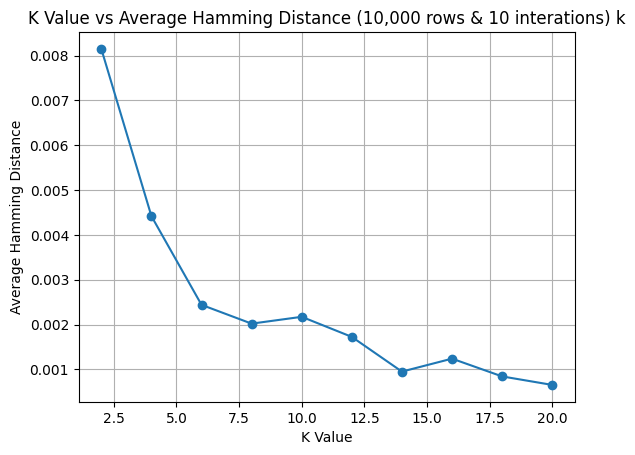

In [15]:
#plot the k value and their corresponding average distances
keys = list(k_values_dict.keys())
values = list(k_values_dict.values())

# Plot
plt.plot(keys, values, marker='o', linestyle='-')
plt.xlabel('K Value')
plt.ylabel('Average Hamming Distance')
plt.title('K Value vs Average Hamming Distance (10,000 rows & 10 interations) k')
plt.grid(True)  # Add grid
plt.savefig('k-values.jpg')
plt.show()

From the graph above, we can see that as the value of k increases, the average distance between clusters and there assigned points tends to go down. In light of efficency, we will be using a k value of 10 to take a deeper dive into how the symptoms are clustered

### Look at Clusters

###### Let's explore, with so many attributes, plotting as clusters on scatterplot will be tough, let's just look at all of the actual diagnoses in a group and see if they look similar

In [117]:
df_features

,E_136_@_7,E_55_@_V_56,E_57_@_V_174,E_130_@_V_11,E_55_@_V_87,E_55_@_V_34,E_130_@_V_138,E_194,E_57_@_V_121,E_133_@_V_89,...,E_152_@_V_173,E_55_@_V_172,E_147,E_112,E_59_@_8,E_132_@_5,E_55_@_V_31,E_58_@_9,E_73,E_55_@_V_148
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
#Cluster of size 10 and we are using a dataset with 100,000 samples
k = 20
clusters = k_modes(df_features, k)

In [119]:
print(clusters)
# print(clusters)

[ 1 15  2 ...  6  1  7]


In [120]:
# Append clustering assignements to the df
df['assignments'] = clusters
df.head()

,AGE,SEX,PATHOLOGY,INITIAL_EVIDENCE,E_136_@_7,E_55_@_V_56,E_57_@_V_174,E_130_@_V_11,E_55_@_V_87,E_55_@_V_34,...,E_55_@_V_172,E_147,E_112,E_59_@_8,E_132_@_5,E_55_@_V_31,E_58_@_9,E_73,E_55_@_V_148,assignments
0,18,M,URTI,E_91,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,21,M,HIV (initial infection),E_50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
2,19,F,Pneumonia,E_77,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,34,F,URTI,E_53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,36,M,URTI,E_201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [121]:
algo_report(df)

Algorithm Clustering Report
-------------------------------------------
Total Samples:  50000
Most Common Symptoms:
              count  percentage
E_204_@_V_10  46432       92.86
E_53          36874       73.75
E_57_@_V_123  27192       54.38
E_66          19259       38.52
E_201         15757       31.51

Avergage Cluster Size: 2500.0
Average Diagnoises: 7.35


In [122]:
#### Print Clustering Reports
for i in range(k):
    cluster_report(df, i)
    print()

Cluster  1  Report
-------------------------------------------
Number of Samples in Cluster:  827
Number of Diagnoses: 6
Diagnoses: ['Pancreatic neoplasm' 'Sarcoidosis' 'Influenza' 'Inguinal hernia' 'SLE'
 'Pneumonia']

Top 3 Diagnosis:  PATHOLOGY
Sarcoidosis            300
Pancreatic neoplasm    261
Influenza              165
Name: count, dtype: int64

Top Inital Symptoms: INITIAL_EVIDENCE
E_53     211
E_163     55
E_9       54
Name: count, dtype: int64

Most In-Common Symptoms:
              count  percentage
E_131_@_V_10    827      100.00
E_132_@_0       827      100.00
E_136_@_0       827      100.00
E_53            821       99.27
E_130_@_V_11    818       98.91

Cluster  2  Report
-------------------------------------------
Number of Samples in Cluster:  2668
Number of Diagnoses: 2
Diagnoses: ['URTI' 'Influenza']

Top 3 Diagnosis:  PATHOLOGY
URTI         2667
Influenza       1
Name: count, dtype: int64

Top Inital Symptoms: INITIAL_EVIDENCE
E_53     464
E_181    407
E_97     367

### First, print all of the clusters

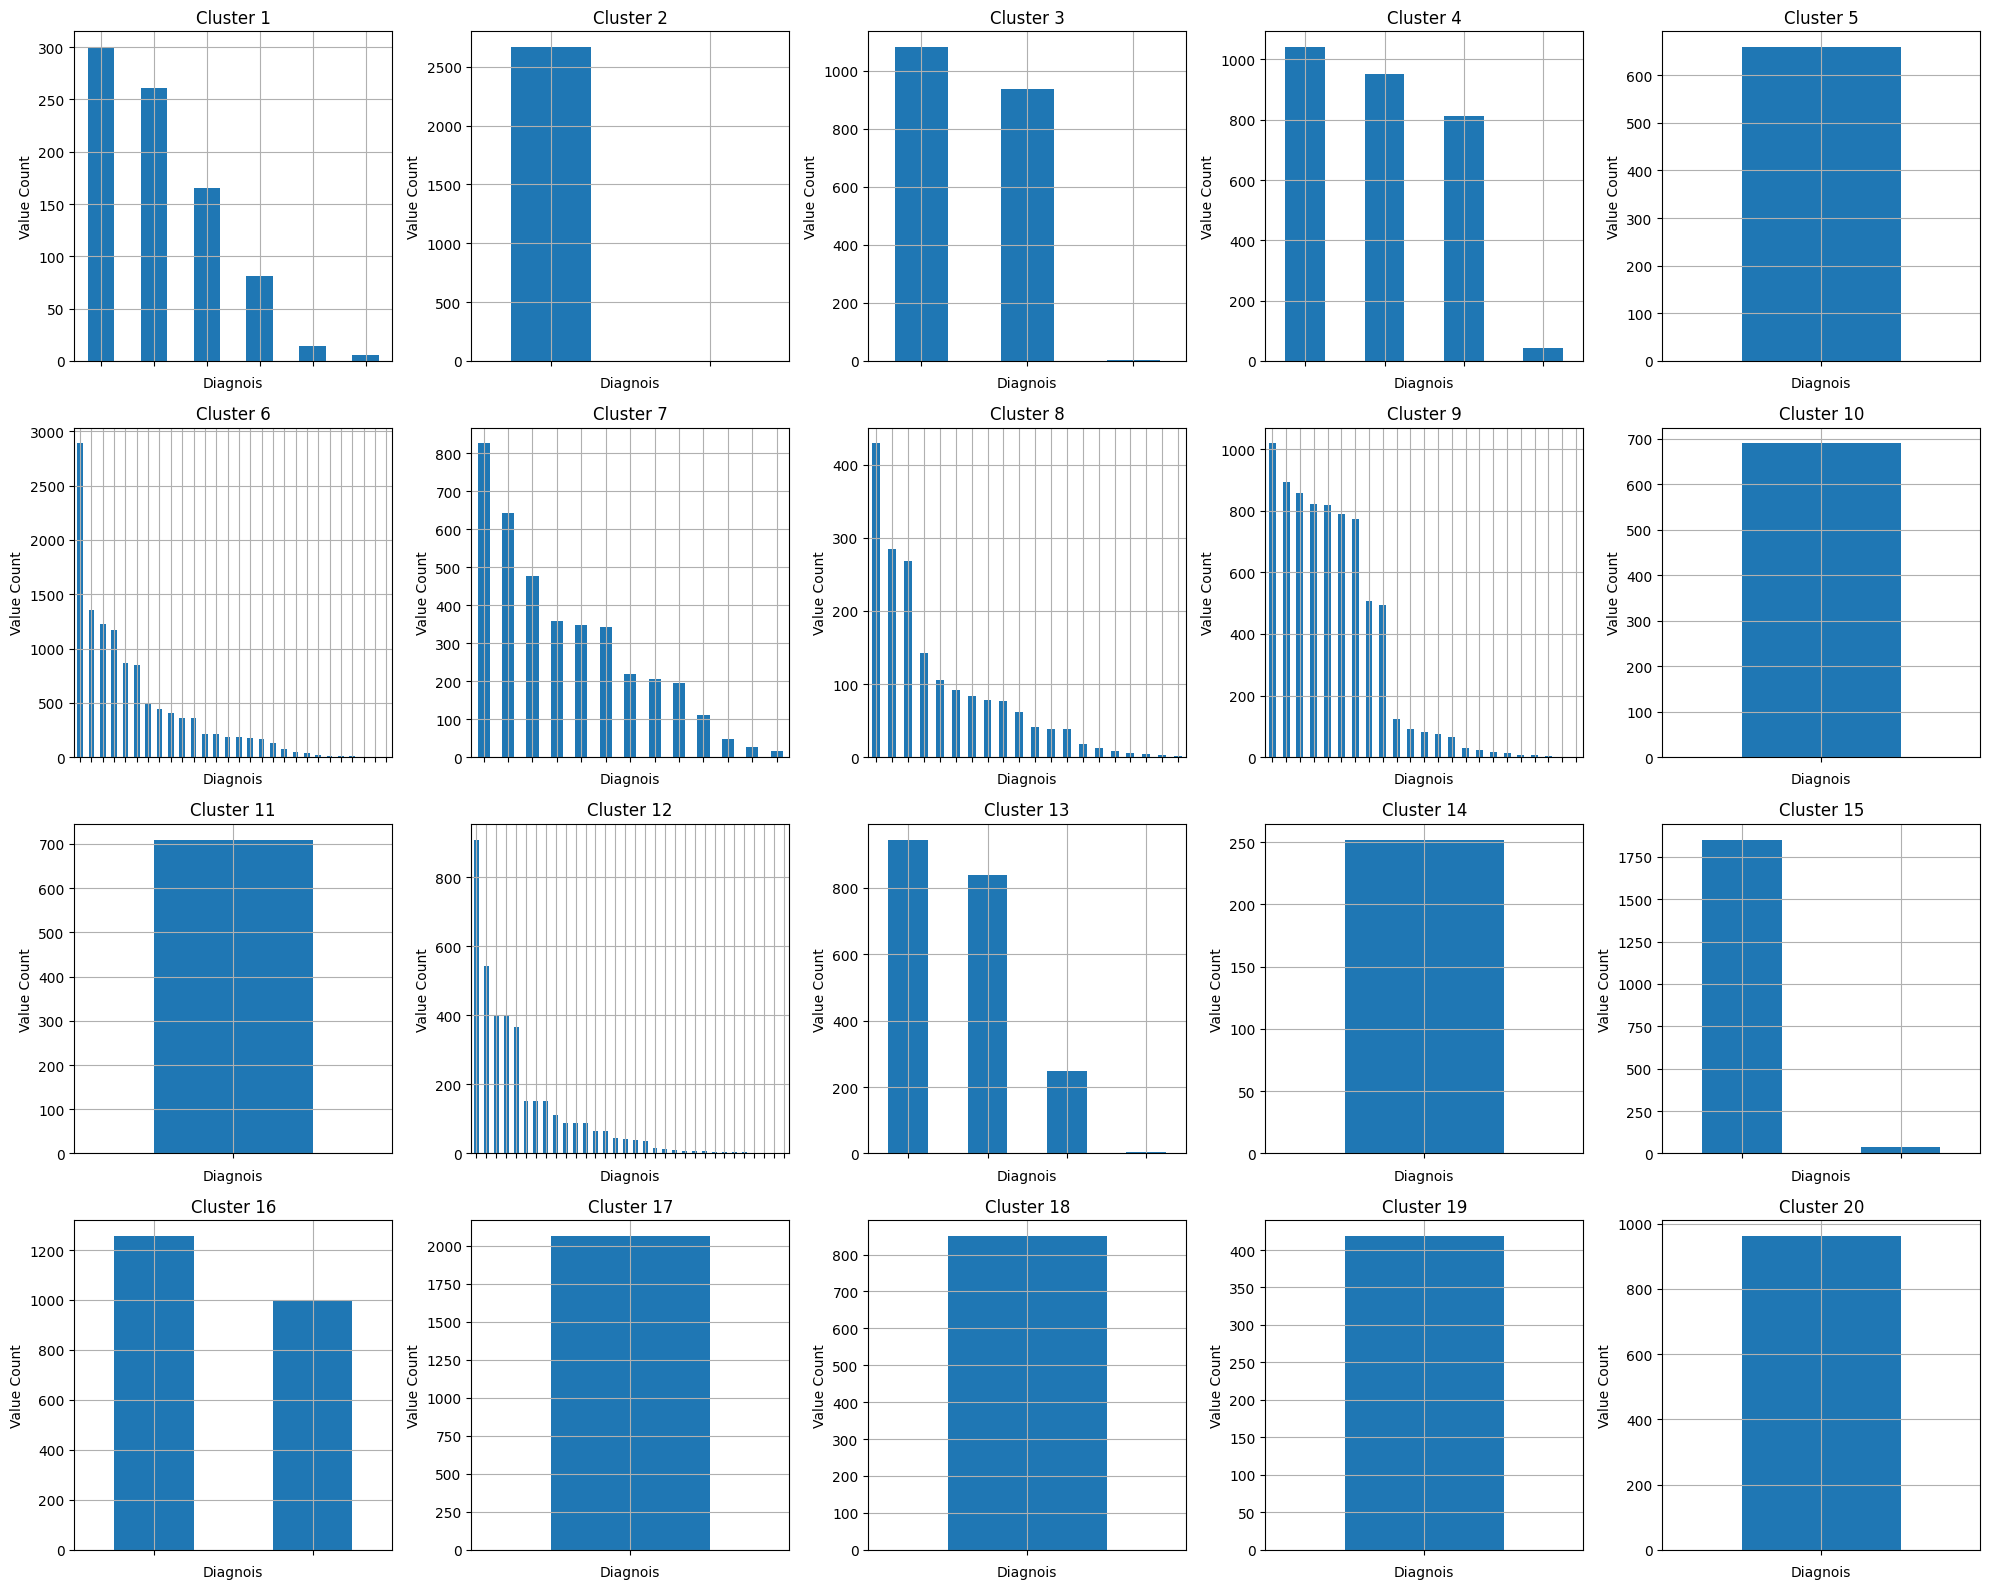

In [123]:
# Assuming k = 20 (4x5 grid)
fig, axs = plt.subplots(4, 5, figsize=(20, 16))

for i, ax in enumerate(axs.flat):
    cluster_n = extract_diagnosis_for_cluster(df, clusters, i)
    counts_n = cluster_n.value_counts()
    counts_n.plot(kind='bar', ax=ax)
    ax.set_title(f'Cluster {i+1}')
    ax.set_xlabel('Diagnois')
    ax.set_ylabel('Value Count')
    ax.set_xticklabels([])
    ax.grid(True)

plt.tight_layout()
plt.savefig('k-values.jpg')
plt.show()


# Agglomerative Clustering

In [ ]:
#Agglomerative clustering logic and visualization libraries 
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

#Using subset of dataset so we can visualize how the clustering happens 
sampled_df_binary = df_binary.sample(n=50, random_state=42)
original_indices = sampled_df_binary.index

#df to use
sampled_df_binary.head()

#Gonna use MCA to dimensionality reduce 
import prince

mca = prince.MCA(n_components=10, random_state=42)
mca.fit(sampled_df_binary)
reduced_features = mca.transform(sampled_df_binary)

print(reduced_features)

#Using previously defined hamming distance is too slow here. Pdist is faster 
distance_matrix = pdist(reduced_features, metric="euclidean")


#Feed into the clustering function 
Z=linkage(distance_matrix, method="average")

In [ ]:
pathology_labels = df.loc[original_indices, 'PATHOLOGY'].values

# Plot dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z, labels=pathology_labels)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.savefig('dendrogram.jpg')
plt.show()

In [ ]:
# import pandas as pd
# from sklearn.cluster import AgglomerativeClustering

# # Extract features
# X = df_binary.values

# # Create an instance of AgglomerativeClustering
# clustering = AgglomerativeClustering(n_clusters=20, linkage='complete')

# # Perform clustering
# cluster_labels = clustering.fit_predict(X)

# # Adding cluster labels to DataFrame
# df = df.drop("assignments", axis=1)
# df['assignments'] = cluster_labels

# print(df)

In [ ]:
# print(X)